---
title: "4Nations Face Off"
description: "Analyze forward line performance at the 4Nations Face off"
author: "chicken"
date: "12/31/2025"
categories:
    - "tutorials"
image: charts/5v5_4n_fo_forwards.png
lightbox: true
---

![](./charts/5v5_4n_fo_forwards.png)

## Housekeeping

### Import dependencies

Import the dependencies we'll need for the guide

In [ ]:
import datetime as dt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from chickenstats.chicken_nhl import Scraper, Season
from chickenstats.chicken_nhl.team import INTERNATIONAL_COLORS, Team
from chickenstats.chicken_nhl._helpers import charts_directory

from pathlib import Path


from bokeh.plotting import figure, output_file, output_notebook, show, save
from bokeh.models import HoverTool, ColumnDataSource, Title, Div, Span
from bokeh.layouts import gridplot, column
from bokeh.models import Range1d

### Pandas options

Set different pandas options. This cell is optional

In [ ]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

### Folder structure

In [ ]:
charts_directory()

### Chickenstats matplotlib style

chickenstats.utilities includes a custom style package - this activates it. This cell is also optional

In [ ]:
plt.style.use("chickenstats")

---

## Scrape data

### Schedule

Scrape the schedule using the `Season` object

In [ ]:
season = Season(2024, backend="pandas")

In [ ]:
schedule = season.schedule(sessions="FO")

Output()

### Game IDs

Create a list of game IDs to scrape

In [ ]:
conds = schedule.game_state.isin(["OFF", "FINAL"])

game_ids = schedule.loc[conds].game_id.unique().tolist()

latest_date = schedule.loc[conds].game_date.max()

### Play-by-play

Scrape play-by-play data using the `Scraper` object

In [ ]:
scraper = Scraper(game_ids, backend="pandas")

In [ ]:
pbp = scraper.play_by_play

Output()

### Stats

Aggregate statistics to season and game level

In [ ]:
scraper.prep_stats(level="season")
season_stats = scraper.stats

Output()

In [ ]:
scraper.prep_stats(level="game")
game_stats = scraper.stats

Output()

In [ ]:
scraper.prep_lines(level="season")
lines = scraper.lines

Output()

In [ ]:
scraper.prep_team_stats(level="season")
team_stats = scraper.team_stats

Output()

## Matplotlib

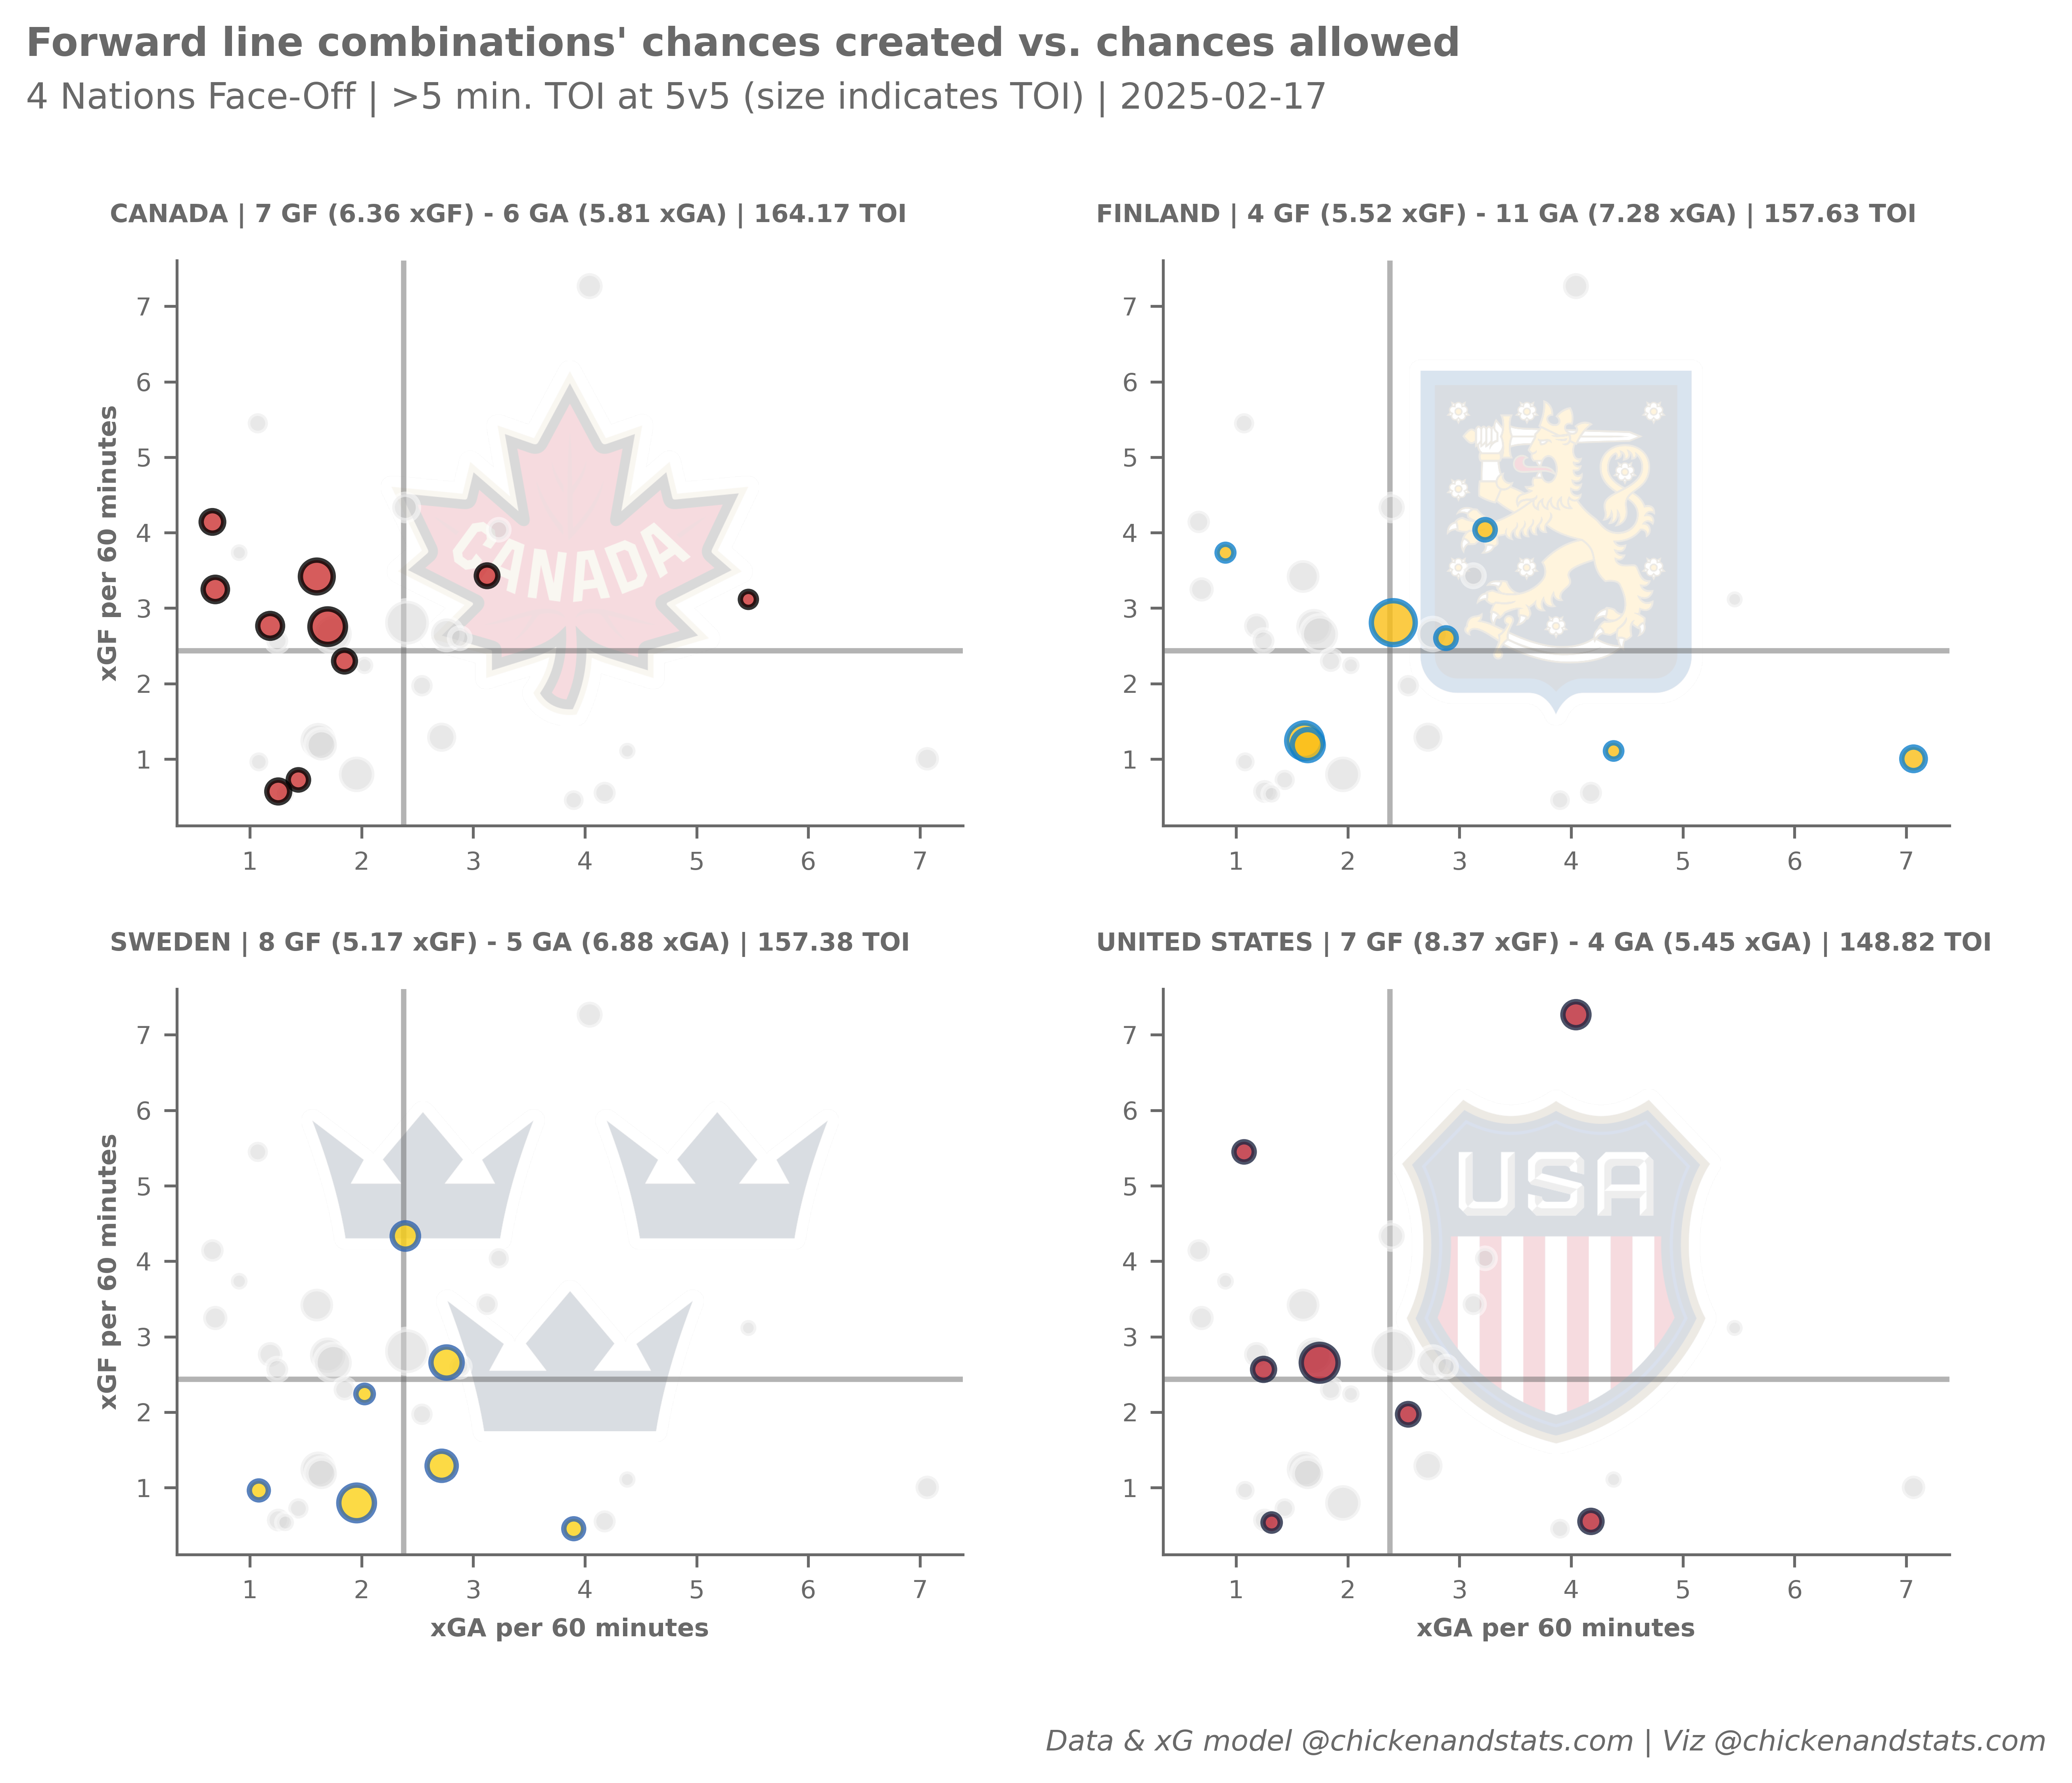

In [ ]:
strength_state = "5v5"
toi_min = 5

# Setting filter conditions and filtering data
conds = np.logical_and(lines.strength_state == strength_state, lines.toi >= toi_min)
plot_lines = (
    lines.loc[conds]
    .sort_values(by="xgf_percent", ascending=False)
    .reset_index(drop=True)
)

# Setting overall figures
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=650, figsize=(8, 6))

fig.tight_layout(pad=2.5)

axes = axes.reshape(-1)

# Getting the averages and drawing the average lines
xga_mean = plot_lines.xga_p60.mean()
xgf_mean = plot_lines.xgf_p60.mean()

# Setting the size norm so bubbles are consistent across figures
size_norm = (plot_lines.toi.min(), plot_lines.toi.max())

# Getting the teams and standings data to iterate through
teams = ["CAN", "FIN", "SWE", "USA"]
team_names = ["CANADA", "FINLAND", "SWEDEN", "UNITED STATES"]
team_names = dict(zip(teams, team_names, strict=False))

# Iterating through the standings data
for _idx, team in enumerate(teams):
    # Setting the team    # Setting the axis
    ax = axes[_idx]

    team_info = Team(team)

    team_name = team_info.team_name
    colors = team_info.colors

    team_stats_plot = team_stats.loc[
        np.logical_and(
            team_stats.strength_state == strength_state, team_stats.team == team
        )
    ]

    # Average lines
    ax.axvline(x=xga_mean, zorder=-1, alpha=0.5)
    ax.axhline(y=xgf_mean, zorder=-1, alpha=0.5)

    # Filtering data and plotting the non-selected teams first
    conds = plot_lines.team != team
    plot_data = plot_lines.loc[conds]

    # They all get gray colors
    facecolor = colors["MISS"]
    edgecolor = "white"  # colors["MISS"]

    # Plotting the non-selected teams' data
    sns.scatterplot(
        data=plot_data,
        x="xga_p60",
        y="xgf_p60",
        size="toi",
        sizes=(20, 150),
        size_norm=size_norm,
        lw=1.5,
        facecolor=facecolor,
        edgecolor=edgecolor,
        alpha=0.5,
        legend=False,
        ax=ax,
    )

    # Filtering and plotting the selected team's data
    conds = plot_lines.team == team
    plot_data = plot_lines.loc[conds]

    # Setting the colors
    facecolor = colors["GOAL"]
    edgecolor = colors["SHOT"]

    # Plotting the selected team's data
    sns.scatterplot(
        data=plot_data,
        x="xga_p60",
        y="xgf_p60",
        size="toi",
        sizes=(20, 150),
        size_norm=size_norm,
        lw=1.5,
        facecolor=facecolor,
        edgecolor=edgecolor,
        alpha=0.8,
        legend=False,
        ax=ax,
    )

    # Setting x and y axes labels
    x_labels = [2, 3]

    if _idx in x_labels:
        ax.axes.set_xlabel("xGA per 60 minutes", fontsize=7)
    else:
        ax.axes.set_xlabel("")

    y_labels = [0, 2]

    if _idx in y_labels:
        ax.axes.set_ylabel("xGF per 60 minutes", fontsize=7)
    else:
        ax.axes.set_ylabel("")

    # Setting tick params font size
    ax.tick_params(axis="both", which="major", labelsize=7)

    gf = team_stats_plot.gf.iloc[0]
    xgf = round(team_stats_plot.xgf.iloc[0], 2)
    ga = team_stats_plot.ga.iloc[0]
    xga = round(team_stats_plot.xga.iloc[0], 2)
    toi = round(team_stats_plot.toi.iloc[0], 2)

    # Setting the ax title
    ax_title = f"{team_name} | {gf} GF ({xgf} xGF) - {ga} GA ({xga} xGA) | {toi} TOI"
    ax.set_title(ax_title, fontsize=7, x=-0.085, y=1.03, horizontalalignment="left")

    logo = team_info.logo

    imagebox = OffsetImage(logo, zoom=0.15, alpha=0.15, zorder=-10)
    imagebox.image.axes = ax

    ab = AnnotationBbox(
        imagebox,
        (0.5, 0.5),
        xycoords="axes fraction",
        bboxprops={"lw": 0},
        alpha=0,
        zorder=-10,
    )

    ax.add_artist(ab)

# Figure suptitle and subtitle
fig_suptitle = "Forward line combinations' chances created vs. chances allowed"
fig.suptitle(
    fig_suptitle,
    x=0.01,
    y=1.085,
    fontsize=11,
    fontweight="bold",
    horizontalalignment="left",
)

subtitle = f"4 Nations Face-Off | >{toi_min} min. TOI at 5v5 (size indicates TOI) | {latest_date}"
fig.text(s=subtitle, x=0.01, y=1.0315, fontsize=10, horizontalalignment="left")

# Attribution
attribution = "Data & xG model @chickenandstats.com | Viz @chickenandstats.com"
fig.text(
    s=attribution,
    x=0.99,
    y=-0.03,
    fontsize=8,
    horizontalalignment="right",
    style="italic",
)

savepath = Path("./charts/5v5_4n_fo_forwards.png")
fig.savefig(savepath, transparent=False, bbox_inches="tight")

## Bokeh

In [ ]:
team = "USA"
team_name = "UNITED STATES"
strength_state = "5v5"
device_type = "desktop"
data = lines.copy()
toi_min = 5
display_plot = True

output_file_str = f"{team.lower()}_5v5_{device_type}.html"

plot_attributes = {
    "desktop": {
        "size_multiplier": 15,
        "major_label_font_size": "9pt",
        "axis_label_font_size": "10pt",
        "title_font_size": "18pt",
        "subtitle_font_size": "14pt",
        "stats_font_size": "10pt",
        "stats_y_value": 0.95,
        "player_name_font_size": "10pt",
        "ncols": 4,
        "height": 240,  # 240,
    },
    "mobile": {
        "size_multiplier": 8,
        "major_label_font_size": "7pt",
        "axis_label_font_size": "8pt",
        "title_font_size": "14pt",
        "subtitle_font_size": "11pt",
        "stats_font_size": "8pt",
        "stats_y_value": 0.95,
        "player_name_font_size": "10pt",
        "ncols": 1,
        "height": 240,  # 240,
    },
}

plot_attributes = plot_attributes[device_type]
plot_colors = {
    "dark_gray": "#696969",
    "light_gray": "#D3D3D3",
    "medium_gray": "#808080",
}

# Setting filter conditions and filtering data
conditions = np.logical_and(
    lines.strength_state == strength_state, lines.toi >= toi_min
)
plot_lines = (
    lines.loc[conditions]
    .sort_values(by="xgf_percent", ascending=False)
    .reset_index(drop=True)
)

x_range = Range1d(plot_lines.xga_p60.min() - 1, plot_lines.xga_p60.max() + 1)
y_range = Range1d(plot_lines.xgf_p60.min() - 1, plot_lines.xgf_p60.max() + 1)

# Getting the averages and drawing the average lines
xga_mean = plot_lines.xga_p60.mean()
xgf_mean = plot_lines.xgf_p60.mean()

# Setting the size norm so bubbles are consistent across figures
size_norm = (plot_lines.toi.min(), plot_lines.toi.max())

# Getting the teams and standings data to iterate through
teams = ["CAN", "FIN", "SWE", "USA"]
team_names = ["CANADA", "FINLAND", "SWEDEN", "UNITED STATES"]
team_names = dict(zip(teams, team_names, strict=False))

plot_list = []

if display_plot:
    output_notebook()

else:
    output_file(output_file_str)

# Iterating through the standings data
for _idx, team in enumerate(teams):
    team_name = team_names[team]
    team_stats_plot = team_stats.loc[
        np.logical_and(
            team_stats.strength_state == strength_state, team_stats.team == team
        )
    ]

    colors = INTERNATIONAL_COLORS[team]

    condition = plot_lines.team == team

    plot_data = plot_lines.loc[condition].copy()

    # plot = prep_stats(data = plot, strengths = strengths)

    plot_data["edgecolors"] = colors["SHOT"]
    plot_data["colors"] = colors["GOAL"]
    plot_data["toi_size"] = plot_data.toi

    source = plot_data.copy()

    source = ColumnDataSource(source)

    TOOLS = "hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,box_select,poly_select,lasso_select"

    p = figure(tools=TOOLS, x_range=x_range, y_range=y_range)

    vline = Span(
        location=xga_mean,
        dimension="height",
        line_color=plot_colors["light_gray"],
        line_width=2,
        level="underlay",
    )
    hline = Span(
        location=xgf_mean,
        dimension="width",
        line_color=plot_colors["light_gray"],
        line_width=2,
        level="underlay",
    )

    p.add_layout(vline)
    p.add_layout(hline)

    test = p.scatter(
        x="xga_p60",
        y="xgf_p60",
        size="toi",
        source=source,
        color="colors",
        alpha=0.65,
        line_color="edgecolors",
        line_width=2.5,
    )

    condition = plot_lines.team != team

    plot_data = plot_lines.loc[condition].copy()

    # plot = prep_stats(data = plot, strengths = strengths)

    plot_data["edgecolors"] = "white"
    plot_data["colors"] = colors["MISS"]
    plot_data["toi_size"] = plot_data.toi

    source = plot_data.copy()

    source = ColumnDataSource(source)

    p.scatter(
        x="xga_p60",
        y="xgf_p60",
        size="toi",
        source=source,
        color="colors",
        alpha=0.65,
        line_color="edgecolors",
        line_width=2.5,
        level="underlay",
    )

    gf = team_stats_plot.gf.iloc[0]
    xgf = round(team_stats_plot.xgf.iloc[0], 2)
    ga = team_stats_plot.ga.iloc[0]
    xga = round(team_stats_plot.xga.iloc[0], 2)
    toi = round(team_stats_plot.toi.iloc[0], 2)

    # Setting the ax title
    subtitle = f"{team_name} | {gf} GF ({xgf} xGF) - {ga} GA ({xga} xGA) | {toi} TOI"

    p.add_layout(
        Title(
            text=subtitle,
            text_font_size=plot_attributes["player_name_font_size"],
            text_font_style="bold",
            text_color=plot_colors["dark_gray"],
            vertical_align="middle",
            align="left",
            text_line_height=1,
        ),
        "above",
    )

    p.outline_line_width = 0
    p.grid.grid_line_color = None
    p.axis.minor_tick_line_color = None
    p.axis.major_tick_line_color = plot_colors["dark_gray"]
    p.axis.major_tick_out = 3
    p.axis.major_tick_line_width = 2.5
    # p.axis.ticker = [0, 0.25, 0.5, 0.75, 1]
    # p.axis.major_label_overrides = {x: f"{round(x * 100)}" for x in [0, 0.25, 0.5, 0.75, 1]}

    p.axis.major_label_text_font_size = plot_attributes["major_label_font_size"]
    p.axis.axis_label_text_font_size = plot_attributes["axis_label_font_size"]
    p.axis.axis_line_color = plot_colors["dark_gray"]
    p.axis.axis_line_width = 2

    p.yaxis.axis_label = "xGF per 60 minutes"

    p.xaxis.axis_label = "xGA per 60 minutes"

    hover = p.select(dict(type=HoverTool))

    hover.tooltips = [
        ("LINE", "@forwards"),
        ("TEAM", "@team"),
        ("TOI", "@toi{0.0}"),
        ("GOALS", "@gf"),
        ("xGF%", "@xgf_percent{0.0%}"),
        ("xGF", "@xgf{0.0}"),
        ("xGA", "@xga{0.0}"),
        ("xGF/60", "@xgf_p60{0.0}"),
        ("xGA/60", "@xga_p60{0.0}"),
    ]
    hover.mode = "mouse"
    hover.name = "tooltips"
    hover.renderers = [test]

    plot_list.append(p)

grid = gridplot(
    plot_list,
    ncols=2,
    toolbar_location="right",
    height=300,  # plot_attributes["height"],
    sizing_mode="stretch_width",
)

title_str = "Forward line combinations' chances created vs. chances allowed"

title = Div(
    text=title_str,
    styles={
        "font-size": plot_attributes["title_font_size"],
        "color": plot_colors["dark_gray"],
        "font-weight": "bold",
    },
    margin=(0, 0, 0, 10),
)

todays_date = dt.datetime.now().strftime("%Y-%m-%d")
subtitle_str = f"4 Nations Face-Off | >{toi_min} min. TOI at 5v5 (size indicates TOI) | {todays_date}"

subtitle = Div(
    text=subtitle_str,
    styles={
        "font-size": plot_attributes["subtitle_font_size"],
        "color": plot_colors["medium_gray"],
        "font-weight": "light",
    },
    margin=(-5, 0, 10, 13),
    background="white",
)

attribution = "Data & xG model @chickenandstats.com | Viz @chickenandstats.com"

footer = Div(
    text=attribution,
    styles={
        "font-size": "10pt",
        "color": plot_colors["medium_gray"],
        "font-weight": "light",
    },
)
# margin=(0, 0, 0, 0))


chart = column(
    title, subtitle, grid, footer, sizing_mode="scale_width", background="white"
)

if display_plot is True:
    show(chart, background_fill_color="white")

else:
    save(chart)

Loading BokehJS ...